In [1]:
import pickle
import warnings

from IPython.display import display
from PIL import Image
import torch

from diffusion_inpaint import Diffusion, create_alpha_schedule

In [2]:
warnings.filterwarnings("ignore")

In [3]:
with open('cifar10.pkl', 'rb') as f:
    full_model = pickle.load(f)
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
print('moving to', device)
full_model['G'].to(device)
print('done')

moving to cuda
done


In [4]:
def display_samples(batch):
    img = batch.clamp(-1, 1).permute(2, 0, 3, 1).reshape([batch.shape[-2], -1, 3])
    arr = ((img.detach().cpu().numpy()+1)*127.5).astype('uint8')
    display(Image.fromarray(arr))

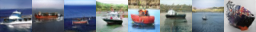

In [5]:
label = torch.zeros(8, 10).to(device)
label[:, 8] = 1

noise = torch.randn(label.shape[0], 512).to(device)
sample = full_model['G'](noise, label, force_fp32=True)
display_samples(sample)

inpaint_me = sample.clone().detach().cpu()

In [6]:
diffusion = Diffusion(create_alpha_schedule(num_steps=500))

In [10]:
def cond_generator(latent):
    return full_model['G'](latent.to(device), label.to(device), force_fp32=True).cpu()
mask = torch.ones_like(inpaint_me)
mask[:, :, :, 16:] = 0
inpainted = diffusion.ddpm_sample_inpaint(
    x_T=torch.randn(inpaint_me.shape[0], 512),
    decoder_fn=cond_generator,
    target=inpaint_me,    # image we want to complete
    mask=mask,            # 1 where we use the target image, 0 elsewhere
    num_samples=1,        # number of image samples to generate per step
    temp=1.0,             # how much to scale the energy gradients
    xstart_temp=0.0,      # how much noise to use when sampling images; 1.0 = unbiased
    clip_std=5.0,         # used for gradient clipping
)
inpainted = cond_generator(inpainted)

100%|██████████| 500/500 [00:45<00:00, 10.94it/s, energy=-410, std=1.04, grad_std=1.35]    


original


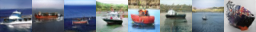

masked


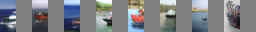

generated completions


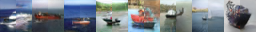

full generated images (ungrounded)


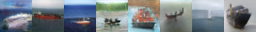

In [11]:
print('original')
display_samples(inpaint_me)
print('masked')
display_samples(inpaint_me*mask)
print('generated completions')
display_samples(inpainted*(1-mask) + inpaint_me*mask)
print('full generated images (ungrounded)')
display_samples(inpainted)